In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, models, layers
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
import tarfile
import collections
import string

In [ ]:
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
r = requests.get(url)
with open("stack_overflow_16k.tar.gz", "wb") as file:
  file.write(r.content)
tar = tarfile.open("stack_overflow_16k.tar.gz")
tar.extractall()

In [ ]:
def tokenize(data, max_words=1000):
  words = []
  for question in data:
    for word in question.split():
      words.append(word)
  words = collections.Counter(words)
  words = sorted(words.items(), key=lambda item: item[1], reverse=True)
  tokens = {}
  t = 1
  for word, _ in words:
    punctuation = all([True if char in string.punctuation else False for char in word])
    if t > max_words:
      break
    if not punctuation:
      tokens[word] = t
      t += 1 
  return tokens

def text_to_tokens(tokens, text_data, sequence_len=325):
  new_data = []
  for question in text_data:
    tokens_list = list(map(lambda word: tokens[word] if word in tokens else 0, question.split()))
    if len(tokens_list) > sequence_len:
      #If greater than sequence_len truncate
      new_data.append(tokens_list[:sequence_len])
    else:
      #If less than sequence_len pad beginning with zeros
      new_data.append([0 for _ in range(sequence_len-len(tokens_list))] + tokens_list)
  return new_data

def read_data(data_dir):
  data = []
  labels = []
  tags = {'csharp' : 0, 'java' : 1, 'javascript' : 2, 'python' : 3}
  for tag in tags:
    folder = os.path.join(data_dir, tag)
    for text_file in os.listdir(folder):
      with open(os.path.join(folder, text_file), 'rb') as f:
        question = f.read().decode('utf-8')
        data.append(question)
        labels.append(tags[tag])
  return data, labels

def get_dataset(data_dir):
  data, labels = read_data(data_dir)
  tokens = tokenize(read_data('train')[0] if data_dir == 'test' else data)
  data = text_to_tokens(tokens, data)
  return np.array(data), np.array(labels), len(tokens)

x_train, y_train, vocab_size = get_dataset('train')
x_test, y_test, _ = get_dataset('test')

In [ ]:
class CNN(Model):
  def __init__(self, vocab_size, embedding_dim):
    super().__init__()
    self.embedding = layers.Embedding(vocab_size, embedding_dim)
    self.conv = models.Sequential([
        layers.Conv1D(16, 3, padding='same', activation='relu'),
        layers.MaxPool1D(),
        layers.Conv1D(32, 3, padding='same', activation='relu'),
        layers.MaxPool1D(),
        layers.Flatten()
    ])
    self.dropout = layers.Dropout(0.5)
    self.prediction = layers.Dense(4)

  def call(self, inputs, training=None):
    embeddings = self.embedding(inputs)
    embeddings = tf.transpose(embeddings, [0,2,1])
    conv_out = self.conv(embeddings)
    if training:
      conv_out = self.dropout(conv_out)
    outputs = self.prediction(conv_out)
    return outputs

model = CNN(vocab_size+1, 16)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    validation_data=(x_test, y_test)
)

Epoch 1/5
125/125 [==============================] - 3s 22ms/step - loss: 1.3858 - accuracy: 0.2626 - val_loss: 1.3817 - val_accuracy: 0.2749
Epoch 2/5
125/125 [==============================] - 3s 20ms/step - loss: 1.2699 - accuracy: 0.4074 - val_loss: 0.9835 - val_accuracy: 0.5864
Epoch 3/5
125/125 [==============================] - 2s 20ms/step - loss: 0.8593 - accuracy: 0.6311 - val_loss: 0.7396 - val_accuracy: 0.7038
Epoch 4/5
125/125 [==============================] - 3s 20ms/step - loss: 0.6414 - accuracy: 0.7471 - val_loss: 0.6871 - val_accuracy: 0.7132
Epoch 5/5
125/125 [==============================] - 3s 21ms/step - loss: 0.5451 - accuracy: 0.7850 - val_loss: 0.6544 - val_accuracy: 0.7343


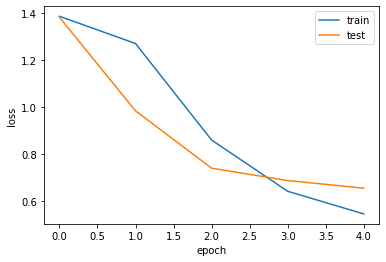

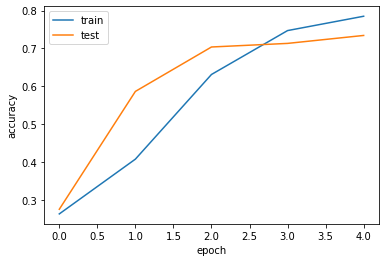

In [ ]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()